In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import random
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.TwitterDataCleaned
DATASET_UNCLEANED = DatasetEnum.TwitterData
SEED_VAL = 777
DATASET_NAME = 'TwitterData'
MODEL_NAME = 'Roberta'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
FROZEN_LAYERS = 9
EPOCHS = 6
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}

# Cross Validation

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-05],
    'regularization': [0, 1e-05],
    'batch_size': [16, 32],
    'epochs': [EPOCHS],
    'frozen_layers': [FROZEN_LAYERS],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Roberta, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

0it [00:00, ?it/s]

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['frozen_layers'] = int(BEST_PARAMS['frozen_layers'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])
print(BEST_PARAMS)

BEST MODEL INFO
{'batch_size': 32.0, 'epochs': 6.0, 'frozen_layers': 9.0, 'learning_rate': 5e-05, 'n_classes': 6.0, 'regularization': 1e-05, 'train_accuracy': 0.9590625, 'train_f1_macro': 0.936812458035139, 'train_f1_micro': 0.9590625, 'val_accuracy': 0.916, 'val_f1_macro': 0.8890029835861673, 'val_f1_micro': 0.916}
RESULTS
   batch_size  epochs  frozen_layers  learning_rate  n_classes  \
0          16       6              9        0.00005          6   
1          32       6              9        0.00005          6   
2          16       6              9        0.00005          6   
3          32       6              9        0.00005          6   
4          16       6              9        0.00001          6   
5          32       6              9        0.00001          6   
6          16       6              9        0.00001          6   
7          32       6              9        0.00001          6   

   regularization  train_accuracy  train_f1_macro  train_f1_micro  \
0         

In [5]:
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

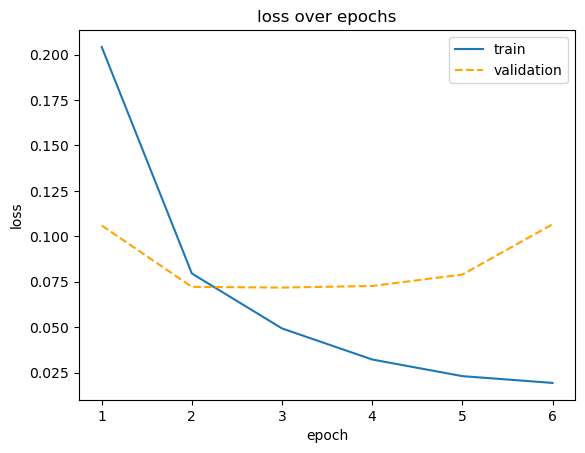

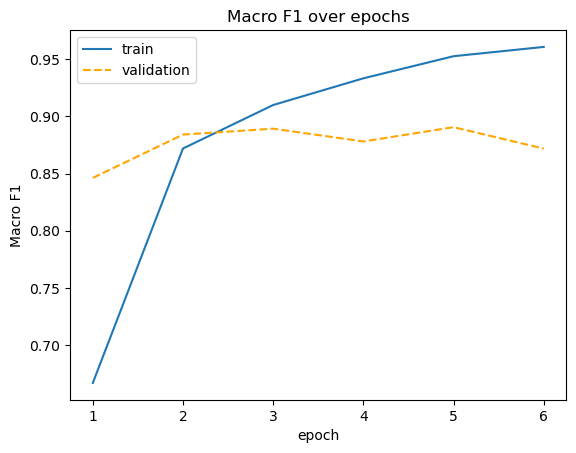

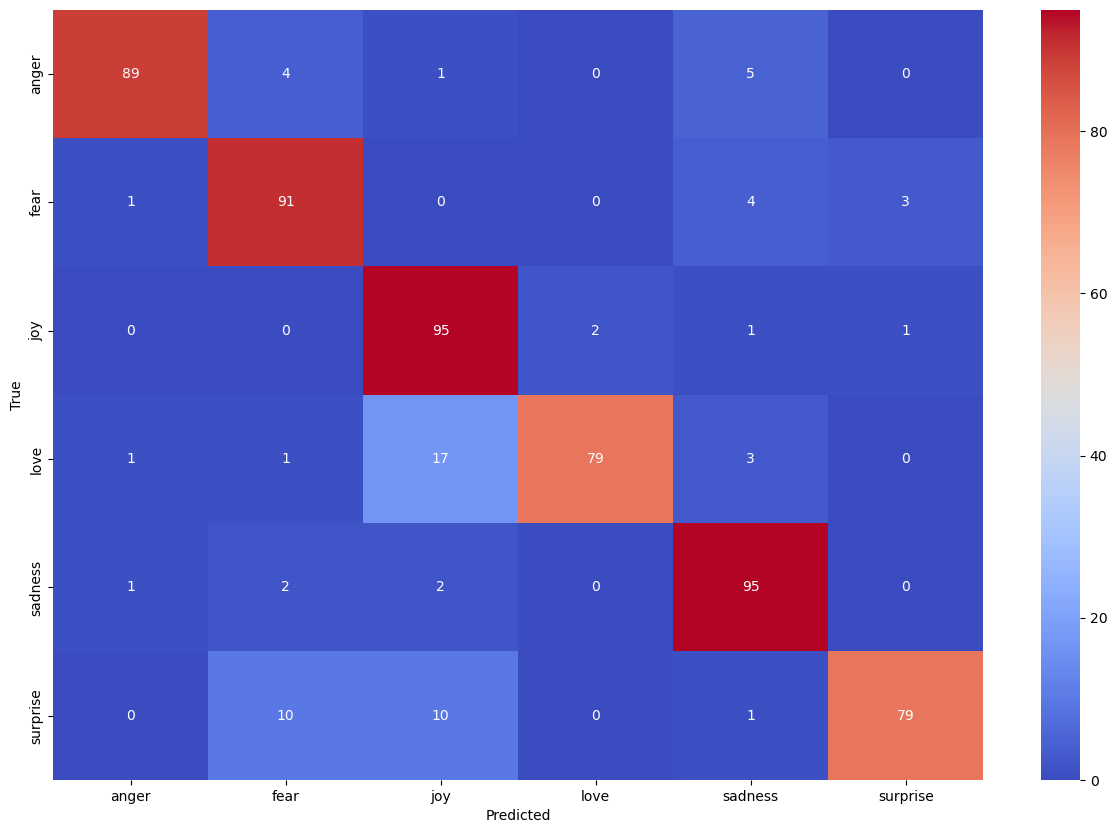

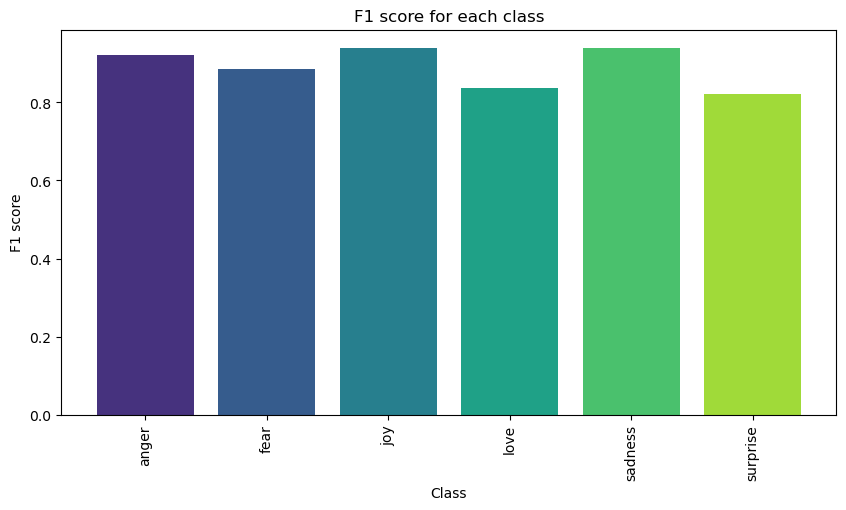

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.95                0.89                0.92                0.85                 275
fear                                0.86                0.91                0.89                0.79                 212
joy                                 0.93                0.95                0.94                0.89                 704
love                                0.89                0.79                0.84                0.72                 178
sadness                             0.93                0.95                0.94                0.89                 550
surprise                            0.85                0.79                0.82                0.70                  81
Macro avg                           0.90                0.88                0.89                0.81                2000
Micro avg

In [12]:
twitter_model_analysis(model, val_df, LABEL_COLS)

## Cleaning Validation

Attempt with no cleaning

In [13]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_uncleaned.pth'
train_df, val_df, test_df = load_dataset(DATASET_UNCLEANED, k_hot_encode=True)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

In [14]:
model = Roberta({'f1_macro':f1}, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True, shuffle_training=False)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

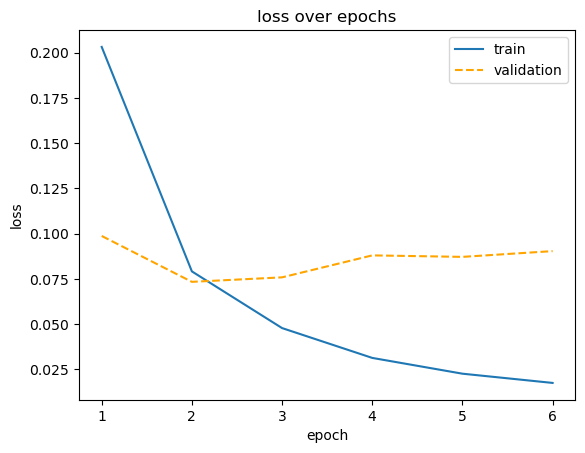

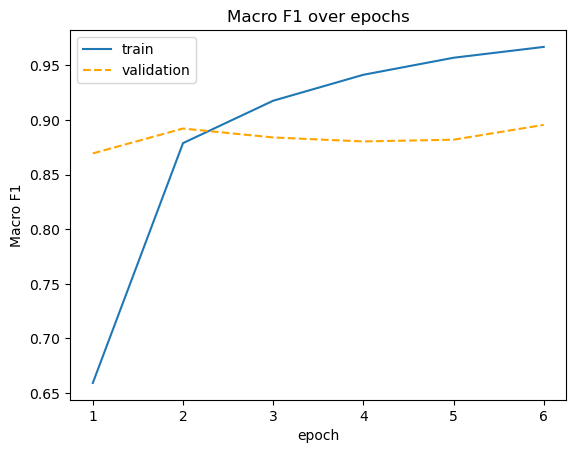

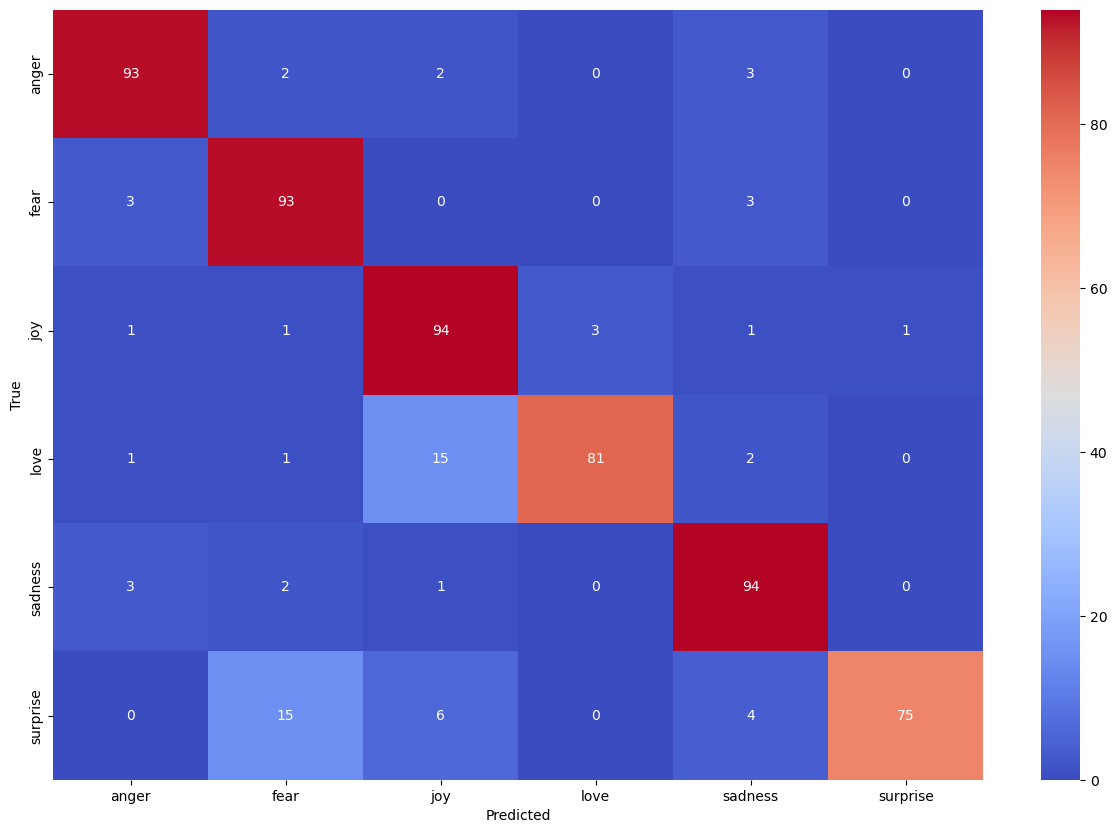

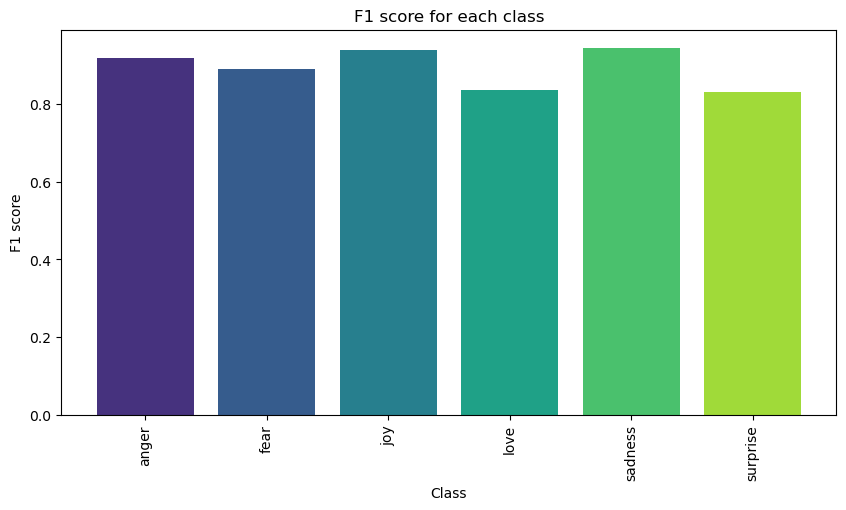

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.91                0.93                0.92                0.85                 275
fear                                0.85                0.93                0.89                0.80                 212
joy                                 0.94                0.94                0.94                0.88                 704
love                                0.86                0.81                0.84                0.72                 178
sadness                             0.95                0.94                0.94                0.89                 550
surprise                            0.92                0.75                0.83                0.71                  81
Macro avg                           0.90                0.89                0.89                0.81                2000
Micro avg

In [15]:
twitter_model_analysis(model, val_df, LABEL_COLS)

In [16]:
out_uncleaned = model.predict(val_df)
target = val_df[LABEL_COLS].values
out_uncleaned = np.argmax(out_uncleaned, axis=1)
# binarize the output
out_uncleaned = np.eye(len(LABEL_COLS))[out_uncleaned]

With cleaning

In [17]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_cleaned_seq.pth'
train_df, val_df, test_df = load_dataset(DATASET)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

In [18]:
model = Roberta({'f1_macro':f1}, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True, shuffle_training=False)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
out_cleaned = model.predict(val_df)
out_cleaned = np.argmax(out_cleaned, axis=1)
# binarize the output
out_cleaned = np.eye(len(LABEL_COLS))[out_cleaned]

Comparison

C:\Users\andre\AppData\Local\Temp\ipykernel_12884\3911376436.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


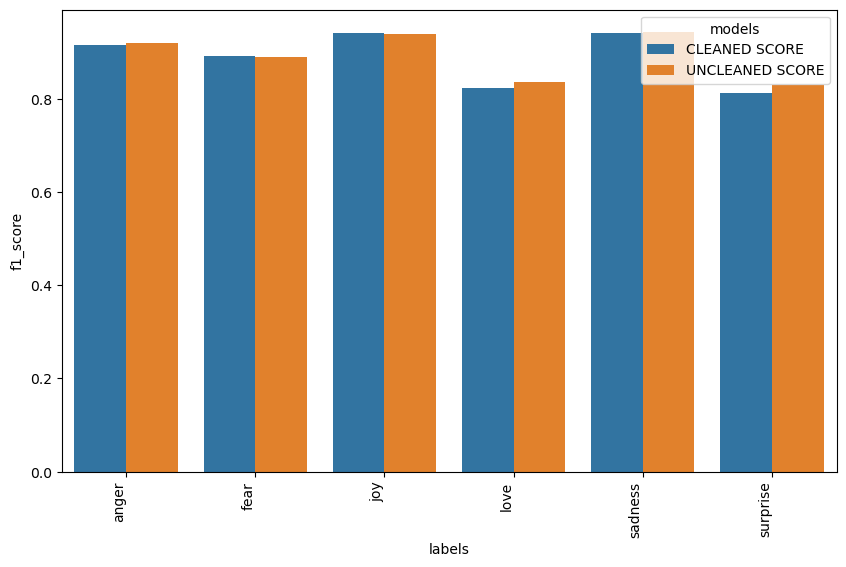

cleaned mean = 0.8878281720785139
uncleaned mean = 0.8928851426278147


In [20]:

cleaned_score = f1_score(target, out_cleaned,average=None)
uncleaned_score = f1_score(target, out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")

# Saving best uncleaned model

In [5]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_best_uncleaned.pth'
train_df, val_df, test_df = load_dataset(DATASET_UNCLEANED, k_hot_encode=True)

In [6]:
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

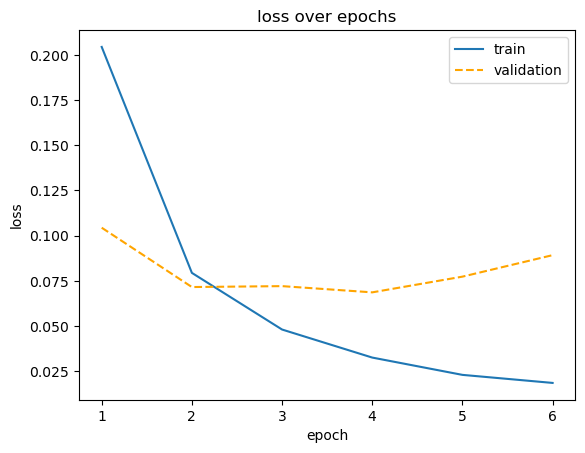

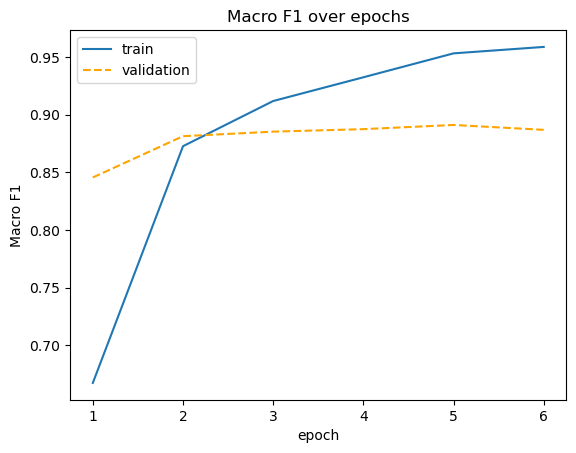

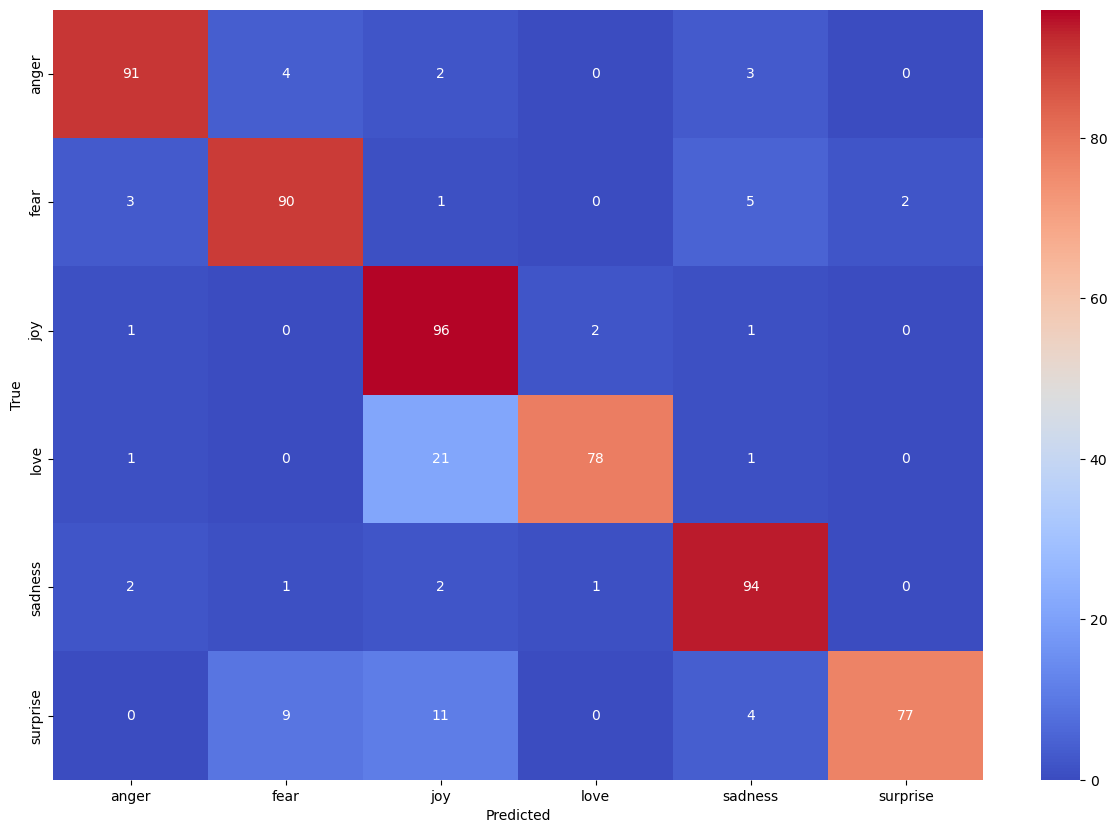

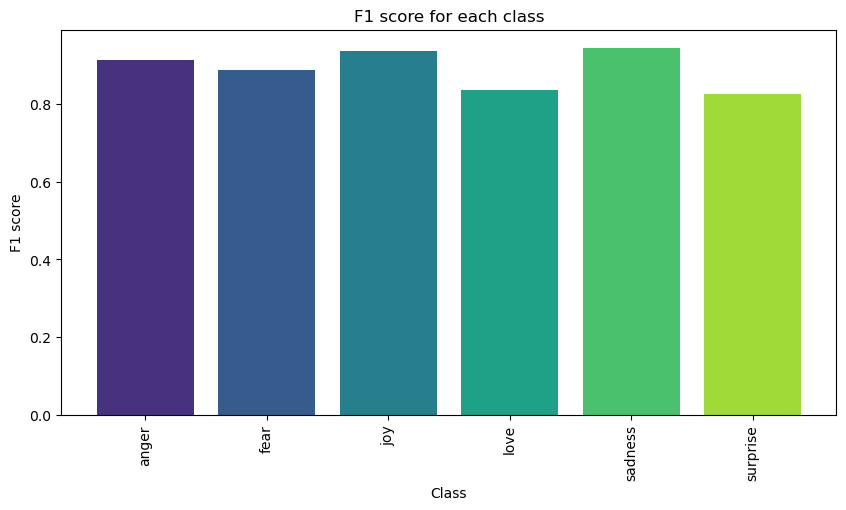

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.92                0.91                0.91                0.84                 275
fear                                0.88                0.90                0.89                0.80                 212
joy                                 0.91                0.96                0.94                0.88                 704
love                                0.90                0.78                0.84                0.72                 178
sadness                             0.95                0.94                0.94                0.89                 550
surprise                            0.90                0.77                0.83                0.70                  81
Macro avg                           0.91                0.88                0.89                0.81                2000
Micro avg

In [7]:
twitter_model_analysis(model, val_df, LABEL_COLS)